# Multiple Try Metropolis Independent Sampler algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

## Define target likelihood function

In [2]:
LAM = 12

def likelihood(x):
    """
    Likelihood of x

    Parameters
    ----------
    x : 1d-array or 2d-array
        Array containing the horizontal and vertical component of one or several
        vectors.

    Returns
    -------
    likelihood : float or 1d-array
        Likelihood of vector x.
    """
    # Convert the argument into 2d-array in order to make this function capable of
    # computing likelihoods for multiple vectors
    x = np.atleast_2d(x)
    x1 = x[:, 0]
    x2 = x[:, 1]
    return np.exp(-(x1 ** 2 + x2 ** 2 + (x1 * x2) ** 2) - 2 * LAM * x1 * x2 / 2)

## Define parameters and trial probability distribution

In [3]:
iterations = int(1e4)  # number of iterations
n_trials = 20  # number of trials
sigma = 3  # sigma for the T(x, y) distribution

In [4]:
# Define trial probability distribution as a Gaussian
trial_distribution = multivariate_normal(
    mean=np.zeros(2), cov=sigma * np.identity(2)
)

## Run MTMIS

In [5]:
# Initialize arrays for sampled points and starting vector x
sampled_points = np.empty((iterations, 2))
x = np.array([0, 0])

# Perform MTMIS
for i in range(iterations):
    
    # Draw independent y_trials given by the predefined Gaussian distribution
    y_trials = trial_distribution.rvs(n_trials)
    # Compute the ratio between likelihood and trial probabilities for each element of
    # y_trials
    weights = likelihood(y_trials) / trial_distribution.pdf(y_trials)
    # Select y among the y_trials with probability of the weights
    # I have to normalize the probabilities in order to sum one
    index = np.random.choice(n_trials, p=weights / weights.sum())
    y = y_trials[index]

    # Compute the weight for x
    weight_x = likelihood(x) / trial_distribution.pdf(x)
    # Compute the probability that will be used to accept or reject y
    rg = min(1, weights.sum() / (weights.sum() - weights[index] + weight_x))
    # Lets accept y with probability rg
    if rg > np.random.rand():
        x = y
    sampled_points[i, :] = x

## Plot results

In [6]:
# Compute target PDF to generate contour plot
x1 = np.linspace(-4, 4, 101)
x1, x2 = np.meshgrid(x1, x1)
target = likelihood(np.hstack((x1[:, np.newaxis], x2[:, np.newaxis])))
target = target.reshape(x1.shape)

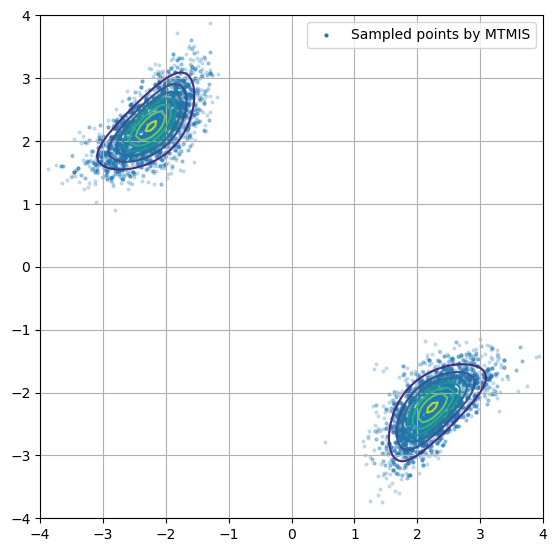

In [9]:
fig, ax = plt.subplots(figsize=(6.66, 6.66), dpi=100)

ax.contour(x1, x2, target)
ax.scatter(
    sampled_points[:, 0],
    sampled_points[:, 1],
    s=4,
    alpha=0.2,
    label="Sampled points by MTMIS",
)
ax.set_aspect("equal")
ax.grid()
legend = ax.legend()
for symbol in legend.legendHandles:
    symbol.set_alpha(1)  # make legend symbol non-transparent
plt.show()